In [1]:
import os, sys
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from neuromaps.images import load_data
from neuromaps.images import dlabel_to_gifti
from netneurotools import datasets as nntdata
from nilearn.datasets import fetch_atlas_schaefer_2018
from statsmodels.stats.multitest import multipletests
from scipy.io import loadmat, savemat
from neuromaps import images, nulls


ref_path = r"D:\OneDrive\References\Farahani_ALS-main\codes" ## https://github.com/netneurolab/Farahani_ALS/tree/main/codes

sys.path.append(ref_path)
from functions import (parcel2fsLR,
                       save_gifti,
                       vasa_null_Schaefer)
from globals import path_results, path_fig, nnodes, path_atlas, path_surface, path_wb_command

In [2]:
nspins  = 1000  # number of null realizations for the spin test

#------------------------------------------------------------------------------
# Load group-averegd W-score data of SUDMEX_TMS
#------------------------------------------------------------------------------
tmp  = loadmat(f'D:\\5_TMS_response\\CT_Wscore53avg_S400_7Net_vHCP2.mat')
disease_profile = tmp['Wscore_s400_7Net'].squeeze()

In [3]:
#------------------------------------------------------------------------------
# Load von-economo atlas information
#------------------------------------------------------------------------------
def load_von_economo_atlas(path_in, nnodes):
    atlas_data = np.squeeze(scipy.io.loadmat(path_in + 'economo_Schaefer400.mat')['pdata'])
    return atlas_data - 1, ['primary motor',
                            'association',
                            'association',
                            'primary/secondary sensory',
                            'primary sensory',
                            'limbic',
                            'insular']
def load_Yeo7_atlas(path_in, nnodes):
    atlas_data = np.squeeze(scipy.io.loadmat(path_in + 'Yeo7_Schaefer400.mat')['yeodata'])
    return atlas_data - 1, ['visual',
                            'somatomotor',
                            'dorsal attention',
                            'salience/ventral attention',
                            'limbic',
                            'control',
                            'default']
    
    

atlas_7Network_von, label_von_networks = load_von_economo_atlas(path_atlas, nnodes)
atlas_7Network_yeo, label_yeo_networks = load_Yeo7_atlas(path_atlas, nnodes)
num_labels = len(label_von_networks)

In [5]:
import numpy as np
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

def compute_network_ttest_vs_zero(disease_profile, atlas_labels_array, atlas_label_names):
    """
    Within each network, a two-tailed one-sample t-test was performed to 
    determine whether its W-score significantly deviated from zero (indicating cortical thinning or thickening)

    inputs：
        disease_profile : array, shape (nnodes,)
        atlas_labels_array : array, shape (nnodes,)   
        atlas_label_names : list of str
            

    outputs:
        result_dict :
            - "network": list of network names
            - "mean_value": mean W-score for each network
            - "p_value": raw p-value from the two-tailed test
            - "p_fdr": FDR-corrected p-value
    """

    num_labels = len(atlas_label_names)
    mean_values = []
    p_values = []

    for i in range(num_labels):
        # extract the W-score
        mask = atlas_labels_array == i
        scores = disease_profile[mask]
        scores = scores[~np.isnan(scores)]  # remove NaN

        mean_values.append(np.mean(scores))

        # two-tailed one-sample t-test: H0: μ == 0
        t_stat, p = ttest_1samp(scores, popmean=0)
        p_values.append(p)  

    # FDR correction
    p_fdr = multipletests(p_values, method='fdr_bh')[1]

    result_dict = {
        "network": atlas_label_names,
        "mean_value": mean_values,
        "p_value": p_values,
        "p_fdr": p_fdr
    }

    return result_dict

In [18]:
result = compute_network_ttest_vs_zero(
    disease_profile=disease_profile,
    atlas_labels_array=atlas_7Network_yeo,
    atlas_label_names=label_yeo_networks
)
for name, mean, p, pfdr in zip(result["network"], result["mean_value"], result["p_value"], result["p_fdr"]):
    print(f"{name:<20} | Mean = {mean:.4f} | p = {p:.4f} | pFDR = {pfdr:.4f}")

visual               | Mean = -0.2486 | p = 0.0000 | pFDR = 0.0000
somatomotor          | Mean = -0.0172 | p = 0.5418 | pFDR = 0.5418
dorsal attention     | Mean = -0.1821 | p = 0.0000 | pFDR = 0.0000
salience/ventral attention | Mean = -0.1632 | p = 0.0000 | pFDR = 0.0000
limbic               | Mean = 0.1062 | p = 0.0772 | pFDR = 0.0901
control              | Mean = -0.2207 | p = 0.0000 | pFDR = 0.0000
default              | Mean = -0.0797 | p = 0.0005 | pFDR = 0.0006


In [6]:
result = compute_network_ttest_vs_zero(
    disease_profile=disease_profile,
    atlas_labels_array=atlas_7Network_von,
    atlas_label_names=label_von_networks
)
for name, mean, p, pfdr in zip(result["network"], result["mean_value"], result["p_value"], result["p_fdr"]):
    print(f"{name:<20} | Mean = {mean:.4f} | p = {p:.4f} | pFDR = {pfdr:.4f}")

primary motor        | Mean = -0.0629 | p = 0.2102 | pFDR = 0.2452
association          | Mean = -0.1264 | p = 0.0000 | pFDR = 0.0000
association          | Mean = -0.0628 | p = 0.0258 | pFDR = 0.0570
primary/secondary sensory | Mean = -0.2564 | p = 0.0000 | pFDR = 0.0000
primary sensory      | Mean = -0.1414 | p = 0.0326 | pFDR = 0.0570
limbic               | Mean = -0.0580 | p = 0.1456 | pFDR = 0.2038
insular              | Mean = -0.0334 | p = 0.6251 | pFDR = 0.6251


In [9]:
##visualization the results
def plot_boxplot(nulls,path_fig=None, name_to_save=None):
    """
    Create a box plot for the null distribution
    and visualize the actual value on top
    """
    fig, axes = plt.subplots(figsize = (7, 4))
    axes.boxplot(nulls, vert=True,flierprops=dict(markersize=6))
    
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    
    plt.tight_layout()
    if name_to_save:
        plt.savefig(os.path.join(path_fig, name_to_save + '.pdf'),dpi=300)
    plt.show()
    

# Get actual/real values for each network  YEO
network_specific_disease_measure_yeo =  []
for label_ind in range(num_labels):
    temp = []
    for roi_ind in range(nnodes):
        if atlas_7Network_yeo[roi_ind] == label_ind:
            temp.append(disease_profile[roi_ind])
    print(np.array(temp).shape)
    network_specific_disease_measure_yeo.append(np.array(temp))   

(61,)
(77,)
(46,)
(47,)
(26,)
(52,)
(91,)


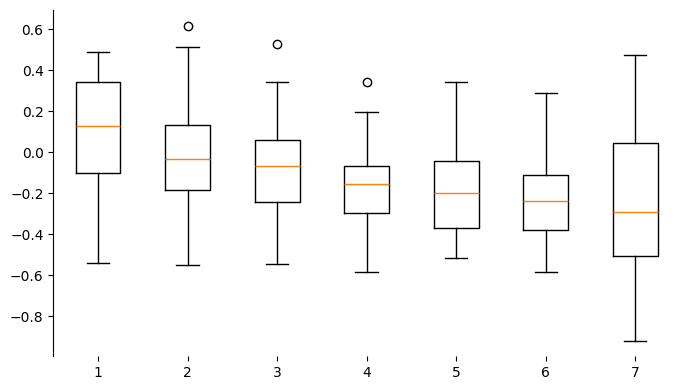

In [16]:
## sort the data YEO
row_medians = [np.nanmedian(arr) for arr in network_specific_disease_measure_yeo]
sorted_indices_Yeo = np.argsort(row_medians)[::-1]
sorted_Yeo_data_TMS = [network_specific_disease_measure_yeo[i] for i in sorted_indices_Yeo]
plot_boxplot(sorted_Yeo_data_TMS,path_fig='D:\\OneDrive\\5_TMS_response\\',
             name_to_save='CT_Wscore53avg_S400_7Net_vHCP2_Yeo_hor')

In [7]:
# Get actual/real values for each network VON
network_specific_disease_measure_von =  []
for label_ind in range(num_labels):
    temp = []
    for roi_ind in range(nnodes):
        if atlas_7Network_von[roi_ind] == label_ind:
            temp.append(disease_profile[roi_ind])
    print(np.array(temp).shape)
    network_specific_disease_measure_von.append(np.array(temp))   

(26,)
(155,)
(77,)
(64,)
(23,)
(39,)
(16,)


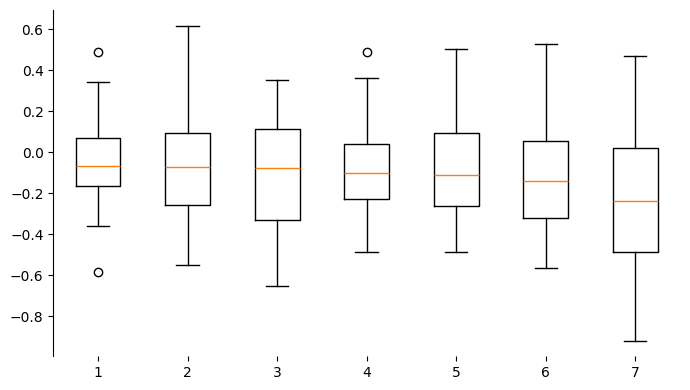

In [10]:
## sort the data VON
row_medians = [np.nanmedian(arr) for arr in network_specific_disease_measure_von]
sorted_indices_von = np.argsort(row_medians)[::-1]
sorted_von_data_TMS = [network_specific_disease_measure_von[i] for i in sorted_indices_von]
plot_boxplot(sorted_von_data_TMS,path_fig='D:\\OneDrive\\5_TMS_response\\',
             name_to_save='CT_Wscore53avg_S400_7Net_vHCP2_von_hor')